# Linear Regression for Stock Valuation with Dividend Discount Model

# Contents
* Introduction
* Dataset
* Normalizing Data
* Computing Cost
* Gradient Descent
* Fair Share Price Prediction Using Dividend Discount Model

# Introduction

The Dividend Discount Model is a method to calculate the fair share price of a stock. This model uses the dividend growth rate and cost of equity to calculate the fair share price of Apple stock. In this project, I implemented linear regression to predict the dividend growth rate, and used the dividend discound model to forecast future fair share prices of apple stock.

The content for this project was derived from Andrew Ng's Machine Learning course and Bekhruzbek Ochilov's Stock Valuation (using the Dividend Discount Model) from Coursera.

In [94]:
%pip install yfinance

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import math
import time
import datetime
import yfinance as yf

%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


# Dataset

**Retreiving Data**

I began by loading the raw data using the yfinance library. I then displayed the available historical data from yahoo about apple stock.

In [95]:
# Define various variables including the stock name, start and end date of data to be stored, and the interval 
ticker = "AAPL"
begin = "2013-01-02"
terminate = "2022-09-10"
period = "1wk"

apple = yf.Ticker(f"{ticker}")
hist = apple.history(start=f"{begin}", end=f"{terminate}", interval=f"{period}")
hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2013-01-01,17.038168,17.074471,15.850031,16.117685,1.991973e+09,0.0,0.0
2013-01-08,16.281036,16.363486,15.336558,15.436236,2.552172e+09,0.0,0.0
2013-01-15,15.330101,15.713123,14.871089,15.382401,2.494178e+09,0.0,0.0
2013-01-22,15.522686,15.843562,13.382686,13.838928,4.777452e+09,0.0,0.0
2013-01-29,14.105658,14.231794,13.598038,13.607883,2.324249e+09,0.0,0.0
...,...,...,...,...,...,...,...
2022-08-09,164.020004,173.389999,163.250000,173.190002,3.125863e+08,0.0,0.0
2022-08-16,172.779999,176.149994,167.139999,167.570007,3.375823e+08,0.0,0.0
2022-08-23,167.080002,171.050003,159.820007,161.380005,3.114818e+08,0.0,0.0


**Loading the Dataset**

I then loaded the relevant data for the task, converting these values into useful ones.
* y_train is the dividends from the corresponding year.
* x_train is the year of the corresponding Apple stock dividends value.

In [96]:
# store quarterly dividend data in array, luckily there is no need to account for stock splits as yahoo already does that
def get_yearly(raw_data, time):
    """
    store quarterly dividend data in array, luckily there is no need to account for stock splits as yahoo already does that
    Args:
      raw_data (ndarray): Input to the function, the yearly dividend data from yfinance
      time (scalar): The time period over which the model will fit to (years) 
    Returns:
      yearly_dataset (ndarray): Array of annual dividends of each year to be analysed
    """
    yearly_dataset = np.zeros(time)
    length = len(raw_data)
    for i in range(0, time):
        j = 4*i
        if j+4 > length:
            if j+3 > length:
                if j+2 > length:
                    yearly_dataset[i] = np.sum(raw_data[j:j+4]*4)
                else:
                    yearly_dataset[i] = np.sum(raw_data[j:j+4]*2)
            else:
                yearly_dataset[i] = np.sum(raw_data[j:j+4]*(4/3))
        else:
            yearly_dataset[i] = np.sum(raw_data[j:j+4])
    return yearly_dataset

In [97]:
time_period = int(terminate[0:4]) - int(begin[0:4]) + 1

x_train = np.linspace(int(begin[0:4]), int(terminate[0:4]), time_period)
y_train = get_yearly(np.array(apple.dividends), time_period)

**View the Variables**

The code below prints the arrays y_train and x_train.

In [98]:
print ("x_train:", x_train)
print ("y_train:", y_train)

x_train: [2013. 2014. 2015. 2016. 2017. 2018. 2019. 2020. 2021. 2022.]
y_train: [0.42143    0.461429   0.5075     0.5575     0.615      0.705
 0.76       0.8075     0.865      0.90666667]


**Visualize the Data**

I used scatter plot to visualize the data.

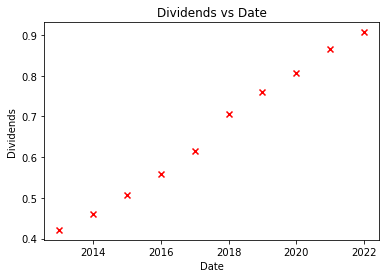

In [99]:
plt.scatter(x_train, y_train, marker='x', c='r') 
# Set the title
plt.title("Dividends vs Date")
# Set the y-axis label
plt.ylabel("Dividends")
# Set the x-axis label
plt.xlabel("Date")
plt.show()

# Normalizing Data

Data normalization is a technique used to manipulate data before implementing machine learning techniques. It provides many advantages including faster implementation of gradient descent. After z-score normalization, all features will have a mean of 0 and a standard deviation of 1.

In [100]:
def zscore_normalize_features(X):
    """
    Normalize features for faster gradient descent
    Args:
      X (ndarray): array of year which will be analysed
    Returns:
      X_norm (ndarray): Array of normalised features
      mu (scalar): average value of array of years
      sigma (scalar): standard deviation of values of years
    """
    # find the mean of each column/feature
    mu     = np.mean(X, axis=0)                 # mu will have shape (n,)
    # find the standard deviation of each column/feature
    sigma  = np.std(X, axis=0)                  # sigma will have shape (n,)
    # element-wise, subtract mu for that column from each example, divide by std for that column
    X_norm = (X - mu) / sigma      
    return (X_norm, mu, sigma)

In [101]:
x_train_norm, mu, sigma = zscore_normalize_features(x_train)
print ("Normalized x_train:", x_train_norm)

Normalized x_train: [-1.5666989  -1.21854359 -0.87038828 -0.52223297 -0.17407766  0.17407766
  0.52223297  0.87038828  1.21854359  1.5666989 ]


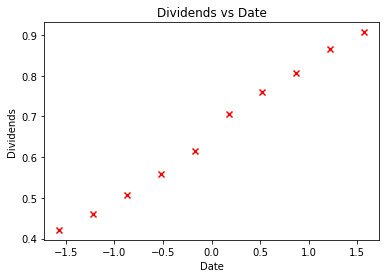

In [102]:
plt.scatter(x_train_norm, y_train, marker='x', c='r') 
# Set the title
plt.title("Dividends vs Date")
# Set the y-axis label
plt.ylabel("Dividends")
# Set the x-axis label
plt.xlabel("Date")
plt.show()

# Computing Cost

Gradient descent involves repeated steps to adjust the value of parameters w and b to gradually get smaller cost (the cost being the difference between the prediction and ground truth). The function below calculates the cost at the given parameter values. The cost function is based on mean squared loss function. The function below iterates over each training sample to get a total loss.

In [103]:
def compute_cost(X, y, w, b): 
    """
    compute cost
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      cost (scalar): cost
    """
    m = X.shape[0]
    cost = 0.0
    for i in range(m):                                
        f_wb_i = np.dot(X[i], w) + b
        cost += (f_wb_i - y[i])**2
    cost = cost / (2 * m)   
    return cost

In [104]:
initial_w = 0
initial_b = 1

cost = compute_cost(x_train_norm, y_train, initial_w, initial_b)
print(f'Cost at initial w: {cost}')

Cost at initial w: 0.07100034140260557


# Gradient Descent

**Computing the Gradient**

Next I will write a function that computes the gradient (partial derivative) with respect to the parameters. The function iterates over each training sample to derive the two required gradients.

In [105]:
def compute_gradient(x, y, w, b): 
    """
    Computes the gradient for linear regression
    Args:
      x (ndarray): Shape (m,) Input to the model (Population of cities) 
      y (ndarray): Shape (m,) Label (Actual profits for the cities)
      w, b (scalar): Parameters of the model  
    Returns
      dj_dw (scalar): The gradient of the cost w.r.t. the parameters w
      dj_db (scalar): The gradient of the cost w.r.t. the parameter b     
     """

    m = x.shape[0]

    dj_dw = 0
    dj_db = 0
    
    for i in range(m):  
        f_wb = w * x[i] + b 
        dj_dw_i = (f_wb - y[i]) * x[i] 
        dj_db_i = f_wb - y[i] 
        dj_db += dj_db_i
        dj_dw += dj_dw_i 
    dj_dw = dj_dw / m 
    dj_db = dj_db / m 

    return dj_dw, dj_db

In [106]:
initial_w = 0
initial_b = 1

tmp_dj_dw, tmp_dj_db = compute_gradient(x_train_norm, y_train, initial_w, initial_b)
print('Gradient at initial w, b (zeros):', tmp_dj_dw, tmp_dj_db)

Gradient at initial w, b (zeros): -0.16345242584583305 0.33929743333333334


**Learning Parameters using gradient descent**

The function below finds the optimal parameters for the linear regression model using batch gradient descent.

In [107]:
def gradient_descent(x, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters): 
    """
    Performs batch gradient descent to learn theta. Updates theta by taking num_iters gradient steps with learning rate alpha
    Args:
      x :    (ndarray): Shape (m,)
      y :    (ndarray): Shape (m,)
      w_in, b_in : (scalar) Initial values of parameters of the model
      cost_function: function to compute cost
      gradient_function: function to compute the gradient
      alpha : (float) Learning rate
      num_iters : (int) number of iterations to run gradient descent
    Returns
      w : (ndarray): Shape (1,) Updated values of parameters of the model after
          running gradient descent
      b : (scalar)                Updated value of parameter of the model after
          running gradient descent
    """
    
    # number of training examples
    m = len(x)
    
    # An array to store cost J and w's at each iteration — primarily for graphing later
    J_history = []
    w_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_dw, dj_db = gradient_function(x, y, w, b )  

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw               
        b = b - alpha * dj_db               

        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            cost =  cost_function(x, y, w, b)
            J_history.append(cost)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0:
            w_history.append(w)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")
        
    return w, b, J_history, w_history #return w and J,w history for graphing

In [108]:
# initialize fitting parameters. Recall that the shape of w is (n,)
initial_w = 0.
initial_b = 1.

# some gradient descent settings
iterations = 1500
alpha = 0.01

w,b,J_hist,W_hist = gradient_descent(x_train_norm, y_train, initial_w, initial_b, compute_cost, compute_gradient, alpha, iterations)
print("w,b found by gradient descent:", w, b)

Iteration    0: Cost     0.07   
Iteration  150: Cost     0.00   
Iteration  300: Cost     0.00   
Iteration  450: Cost     0.00   
Iteration  600: Cost     0.00   
Iteration  750: Cost     0.00   
Iteration  900: Cost     0.00   
Iteration 1050: Cost     0.00   
Iteration 1200: Cost     0.00   
Iteration 1350: Cost     0.00   
w,b found by gradient descent: 0.1634523794815801 0.6607026629104021


**Visualising Prediction**

Below I plot the cost vs iteration and the predicted values with the ground truth data points.

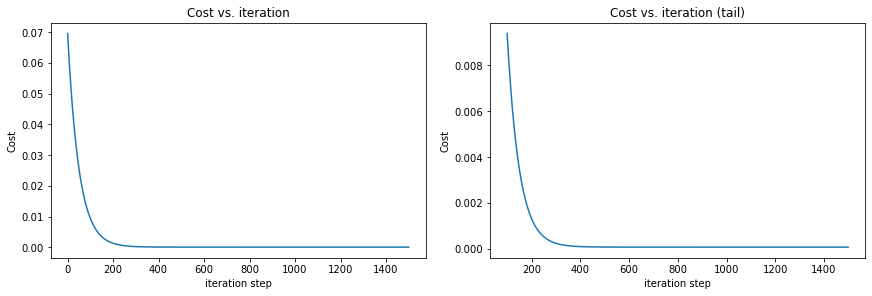

In [109]:
# plot cost versus iteration  
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
ax1.plot(J_hist)
ax2.plot(100 + np.arange(len(J_hist[100:])), J_hist[100:])
ax1.set_title("Cost vs. iteration");  ax2.set_title("Cost vs. iteration (tail)")
ax1.set_ylabel('Cost')             ;  ax2.set_ylabel('Cost') 
ax1.set_xlabel('iteration step')   ;  ax2.set_xlabel('iteration step') 
plt.show()

In [110]:
prediction_current = (w*x_train_norm)+b

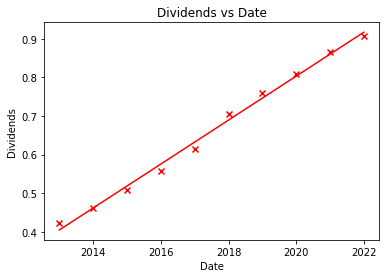

In [111]:
plt.plot(x_train, prediction_current, c='r') 

plt.scatter(x_train, y_train, marker='x', c='r')
# Set the title
plt.title("Dividends vs Date")
# Set the y-axis label
plt.ylabel("Dividends")
# Set the x-axis label
plt.xlabel("Date")
plt.show()

# Fair Share Price Prediction Using Dividend Discount Model

**Find dividend growth rate**

Below, I used the Dividend Discount Model to forecast the future fair share prices of stocks. I began by writing a function to compute future dividend growth rates.

In [112]:
def growth_rate(prediction):
    """
    Derive annual predicted growth rate based on dividend data
    Args:
      prediction (ndarray): predicted dividends
    Returns:
      prediction_growth (ndarray): predicted growth rate
    """
    prediction_period = len(prediction)
    predicted_growth = np.zeros(prediction_period-1)
    for i in range (1, prediction_period):
        predicted_growth[i-1] = prediction[i]/prediction[i-1] - 1
    return predicted_growth

In [113]:
end_predict = 2030
beg_predict = int(terminate[0:4])+1

x_predict = np.linspace(beg_predict, end_predict, (end_predict-beg_predict)+1)
x_predict_1 = np.linspace(beg_predict-1, end_predict, (end_predict-beg_predict)+2)
x_predict_norm = (x_predict - mu) / sigma
x_predict_norm_1 = (x_predict_1 - mu) / sigma
prediction = (w*x_predict_norm)+b
prediction_1 = (w*x_predict_norm_1)+b
prediction_growth = growth_rate(prediction_1)

print(prediction_growth)


[0.06207226 0.05844448 0.05521733 0.05232792 0.04972587 0.04737034
 0.04522788 0.04327083]


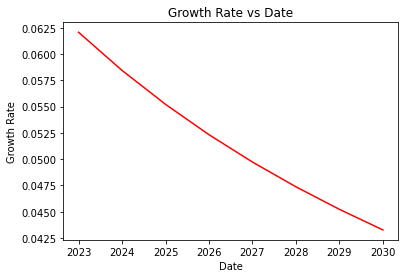

In [114]:
plt.plot(x_predict, prediction_growth, c='r') 
# Set the title
plt.title("Growth Rate vs Date")
# Set the y-axis label
plt.ylabel("Growth Rate")
# Set the x-axis label
plt.xlabel("Date")
plt.show()

**Find Cost of Equity**

Next, I wrote a function to calculate cost of equity.

In [115]:
def cost_of_equity(Market_Ticker, Stock_Ticker, risk_free_rate, term):
    """
    calculate cost of equity
    Args:
      Market_Ticker (string): Ticker for ETF which represents market stock being analysed is in
      Stock_Ticker (string): Ticker for Stock
      risk_free_rate (scalar): the rate of return of an investment with zero risk. The risk-free rate represents the interest an investor would expect from an absolutely risk-free investment over a specified period of time.
      term (string): end year for analysis
    Returns:
      cost_of_equity (scalar): the return a firm theoretically pays to its equity shareholders to compensate for the risk they undertake by investing in them
    """
    period = "1wk"
    VGT = yf.Ticker(f"{Market_Ticker}")
    market_hist = VGT.history(start="2005-01-01", end=f"{term}", interval=f"{period}")
    market_return = ((market_hist["Close"][-1]/market_hist["Close"][0])**(1/(int(terminate[:4])-2005)))-1
    Tick = yf.Ticker(f"{Stock_Ticker}")
    beta = Tick.info["beta"]
    cost_of_equity = risk_free_rate + (beta * (market_return - risk_free_rate))
    return cost_of_equity

In [116]:
#risk free rate was 3% as of 2019
Risk_Free = 0.03

# Define various variables including the stock name, start and end date of data to be stored, and the interval
# A popular tech ETF "Vanguard Information Technology Index Fund ETF" was chosen to represent the market apple is in
market_ticker = "VGT"
period = "1wk"

cost_equity = cost_of_equity(market_ticker, ticker, Risk_Free, terminate)

print(f"Cost of Equity: {cost_equity}")

Cost of Equity: 0.16359883094425332


**Calulating Fair Share Price**

Next, I calculated the fair share price of apple stock.

In [117]:
def Fair_Share_Price(prediction_div, prediction_growth, cost_of_equity):
    Fair_Share = (prediction_div * (prediction_growth+1))/((prediction_growth-cost_of_equity)*(-1))
    return Fair_Share

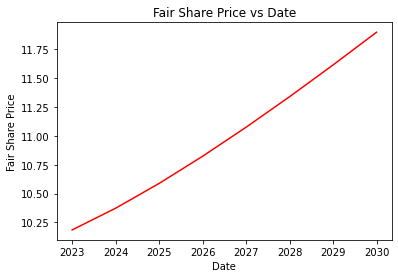

In [118]:
plt.plot(x_predict, Fair_Share_Price(prediction, prediction_growth, cost_equity), c='r') 
# Set the title
plt.title("Fair Share Price vs Date")
# Set the y-axis label
plt.ylabel("Fair Share Price")
# Set the x-axis label
plt.xlabel("Date")
plt.show()